# Pothole Avoidance

In [1]:
import os
import pandas as pd
import numpy as np

def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c * 1000  # convert to meters

    return distance

def process_log_line(line):
    if "Feedback Code Starting" in line:
        return None

    sections = line.split(' :- ')

    if len(sections) != 2:
        return None

    log_timestamp = sections[0].strip().split(',')[0]
    log_details = sections[1].strip()

    details_parts = log_details.split(':')
    log_seq = details_parts[0]
    data_dict = {'Log_seq': int(log_seq)}

    mabx_values = [item.strip() for item in details_parts[1:]]
    data_dict['Timestamp'] = log_timestamp
    seq, veh_speed, tire_angle = map(float, mabx_values[0].split('||')[0].split(','))

    data_dict['MABX_seq'] = int(seq)
    data_dict['Veh_MABX_Speed'] = veh_speed
    data_dict['Tire_Angle'] = tire_angle

    # unix_time = mabx_values[0].split('||')[1].strip().split(',')[0]
    
    gnss_values = mabx_values[0].split('||')[1].strip().split(',')
    if len(gnss_values) == 10:
        unixtime, lat, lng, lat_std, lng_std, gnss_speed, acc, roll, pitch, heading = map(float, gnss_values)
        data_dict['Unixtime'] = int(unixtime)
        data_dict['Lat'] = lat
        data_dict['Lng'] = lng
        data_dict['Lat_std'] = lat_std
        data_dict['Lng_std'] = lng_std
        data_dict['Veh_GNSS_Speed'] = gnss_speed
        data_dict['Z_Acc'] = acc
        data_dict['Roll'] = roll
        data_dict['Pitch'] = pitch
        data_dict['Heading'] = heading
    else:
        # print(f"Skipping line due to unexpected number of values: {len(gnss_values)} in line: {line}")
        return None

    return data_dict

def read_and_process_log_file(file_path, dataframe):
    with open(file_path, 'r') as file:
        file_content = file.read()

    file_lines = file_content.split('\n')

    data_list = []

    for line in file_lines:
        data_dict = process_log_line(line)
        if data_dict is not None:
            data_list.append(data_dict)

    if data_list:
        dataframe = pd.concat([dataframe, pd.DataFrame(data_list)], ignore_index=True)

    return dataframe


def find_nearest_point(reference_lat, reference_lon, df):
    """
    Find the nearest point in the DataFrame `df` to the given reference latitude and longitude.
    """
    # Calculate the distance from each point in the DataFrame to the reference point
    distances = df.apply(lambda row: haversine_vectorized(reference_lat, reference_lon, row['Lat'], row['Lng']), axis=1)

    # Find the index of the point with the smallest distance
    nearest_idx = distances.idxmin()

    # Retrieve the information about the nearest point
    nearest_point_info = df.loc[nearest_idx]

    return nearest_point_info

data = {}

# extract all the folders in the directory

# Specify the directory path
directory_path = '/home/ninerishav/TiHANLab-Codes/Solio-Suzuki/navigation/SingletonCodes/autonomous-mode/Shared-To-Suzuki/pothole-inside'

items = os.listdir(directory_path)
items.sort()
folder_paths = [os.path.join(directory_path, item) for item in items if os.path.isdir(os.path.join(directory_path, item))]

given_start_lat, given_start_lon = 17.60173042438856, 78.12660632898064

# Process log files in each folder path
for folder_path in folder_paths:
    folder_name = os.path.basename(os.path.normpath(folder_path))  # Get the last word of the path

    # Initialize DataFrames for each type
    auto10_df = pd.DataFrame()
    auto20_df = pd.DataFrame()
    auto30_df = pd.DataFrame()

    for filename in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith(".log") and os.path.isfile(file_path):
            if 'cone10' in filename:
                auto10_df = read_and_process_log_file(file_path, auto10_df)
                nearest_point_auto10 = find_nearest_point(given_start_lat, given_start_lon, auto10_df)
                auto10_df['nearest_dist_from_start'] = haversine_vectorized(nearest_point_auto10['Lat'], nearest_point_auto10['Lng'], auto10_df['Lat'], auto10_df['Lng'])
            elif 'cone20' in filename:
                auto20_df = read_and_process_log_file(file_path, auto20_df)
                nearest_point_auto20 = find_nearest_point(given_start_lat, given_start_lon, auto20_df)
                auto20_df['nearest_dist_from_start'] = haversine_vectorized(nearest_point_auto20['Lat'], nearest_point_auto20['Lng'], auto20_df['Lat'], auto20_df['Lng'])
            elif 'cone30' in filename:
                auto30_df = read_and_process_log_file(file_path, auto30_df)
                nearest_point_auto30 = find_nearest_point(given_start_lat, given_start_lon, auto30_df)
                auto30_df['nearest_dist_from_start'] = haversine_vectorized(nearest_point_auto30['Lat'], nearest_point_auto30['Lng'], auto30_df['Lat'], auto30_df['Lng'])

    # Add the DataFrames to the main data dictionary using the folder name as the key
    data[folder_name] = {
        'cone10': auto10_df.copy(),
        'cone20': auto20_df.copy(),
        'cone30': auto30_df.copy(),
    }

    # Confirm that the dataframes are not empty
    for key, value in data[folder_name].items():
        if value.empty:
            print(f"Empty DataFrame for {folder_name} - {key}")


### Some Information about the dataframe

In [2]:
print(f"Number of drivers: {len(data)}")

Number of drivers: 5


In [3]:
data['Aravind']['cone20'].head()

Log_seq            Timestamp  MABX_seq  Veh_MABX_Speed  Tire_Angle  \
0        2  2024-01-24 12:40:04         5            20.0        -0.2   
1        3  2024-01-24 12:40:04         8            20.0        -0.2   
2        4  2024-01-24 12:40:04        11            20.0        -0.2   
3        5  2024-01-24 12:40:04        14            20.0        -0.2   
4        6  2024-01-24 12:40:04        17            20.0        -0.2   

     Unixtime        Lat        Lng  Lat_std  Lng_std  Veh_GNSS_Speed  Z_Acc  \
0  1706080204  17.601696  78.126609     0.01     0.01           25.79  10.03   
1  1706080204  17.601696  78.126609     0.01     0.01           25.79  10.52   
2  1706080204  17.601696  78.126609     0.01     0.01           25.72   9.83   
3  1706080204  17.601703  78.126609     0.01     0.01           25.72   9.93   
4  1706080204  17.601703  78.126609     0.01     0.01           25.72   9.83   

   Roll  Pitch  Heading  nearest_dist_from_start  
0  0.95  -0.53   359.19                 3.602191  
1  0.94  -0.53   359.23                 3.602191  
2  0.93  -0.56   359.31                 3.602191  
3  0.96  -0.58   359.35                 2.884499  
4  1.02  -0.57   359.40                 2.884499

In [4]:
data['Aravind']['cone20'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Log_seq                  649 non-null    int64  
 1   Timestamp                649 non-null    object 
 2   MABX_seq                 649 non-null    int64  
 3   Veh_MABX_Speed           649 non-null    float64
 4   Tire_Angle               649 non-null    float64
 5   Unixtime                 649 non-null    int64  
 6   Lat                      649 non-null    float64
 7   Lng                      649 non-null    float64
 8   Lat_std                  649 non-null    float64
 9   Lng_std                  649 non-null    float64
 10  Veh_GNSS_Speed           649 non-null    float64
 11  Z_Acc                    649 non-null    float64
 12  Roll                     649 non-null    float64
 13  Pitch                    649 non-null    float64
 14  Heading                  6

In [5]:
data['Aravind']['cone30'].describe()

Log_seq    MABX_seq  Veh_MABX_Speed  Tire_Angle      Unixtime  \
count  541.000000  541.000000      541.000000  541.000000  5.410000e+02   
mean   277.621072  128.578558       22.204806   -0.508688  1.706080e+09   
std    159.654368   71.788732        6.148467    3.370803  4.753882e+00   
min      2.000000    0.000000       11.600000  -16.600000  1.706080e+09   
25%    140.000000   68.000000       17.200000   -1.100000  1.706080e+09   
50%    277.000000  130.000000       20.900000   -0.200000  1.706080e+09   
75%    416.000000  188.000000       28.600000    0.000000  1.706080e+09   
max    556.000000  255.000000       35.000000    8.500000  1.706080e+09   

              Lat         Lng       Lat_std     Lng_std  Veh_GNSS_Speed  \
count  541.000000  541.000000  5.410000e+02  541.000000      541.000000   
mean    17.602188   78.126605  1.000000e-02    0.011349       22.820296   
std      0.000262    0.000008  1.319610e-16    0.003420        6.513159   
min     17.601669   78.126594  1.000000e-02    0.010000       12.080000   
25%     17.602003   78.126597  1.000000e-02    0.010000       17.550000   
50%     17.602197   78.126605  1.000000e-02    0.010000       21.320000   
75%     17.602414   78.126609  1.000000e-02    0.010000       28.620000   
max     17.602605   78.126620  1.000000e-02    0.020000       35.720000   

            Z_Acc        Roll       Pitch     Heading  nearest_dist_from_start  
count  541.000000  541.000000  541.000000  541.000000               541.000000  
mean     9.803235    0.968226   -0.320665  241.474917                51.435353  
std      0.354098    0.607638    0.458911  165.401512                28.508602  
min      7.840000   -0.570000   -1.350000    0.010000                 0.000000  
25%      9.600000    0.630000   -0.720000    9.010000                30.518069  
50%      9.820000    0.990000   -0.270000  355.080000                52.101155  
75%     10.020000    1.330000    0.020000  357.510000                76.241668  
max     11.470000    2.200000    0.830000  359.990000                97.417819

#### Exact Coordinates of Pothole

In [6]:
# Given data
coordinates = [
    [17.60212920034102,78.12660001252421],
[17.602129205336254,78.1266000542438],
[17.60212921184398,78.12660005133608],
[17.602129213015047,78.1265999961345],
[17.60212921295533,78.12659998326836],
[17.602129197994497,78.12659998115265],
[17.602129195145196,78.12659998318172],
[17.60212919067419,78.12660000452459],
[17.602129188389295,78.12660000922517],
[17.602129191403506,78.12660000529944],
[17.602129196021263,78.12659999920172],
[17.602129214420856,78.12659999764647],
[17.602129212119863,78.12660000299401],
[17.602129225311288,78.12660002454331],
[17.602129224460686,78.12660002807299],
[17.602129204381544,78.12660001001785],
[17.60212920944943,78.12660001111456],
[17.602129209057633,78.12660001736165],
[17.6021292038509,78.12660000433704],
[17.602129195525006,78.12660001294643],
[17.602129197239716,78.12660001561063],
[17.60212922970704,78.12659999643618],
[17.602129201367628,78.12660004648555],
[17.602129183615848,78.12660007331219],
[17.602129172863943,78.12660006778376],
[17.602129180239363,78.12660007376188],
[17.602129186204376,78.12660005962182],
[17.6021291983505,78.12660007223636],
[17.602129210014883,78.12660007212428],
[17.6021292080456,78.12660007746132],
[17.60212920379557,78.12660006787422],
[17.60212918556187,78.12660007254686],
[17.60212918626751,78.12660006483189],
[17.602129189863582,78.12660009322515],
[17.60212921206086,78.12660009153359],
[17.60212920481641,78.12660007864112],
[17.602129206941893,78.12660007402059],
[17.60212920892319,78.1266000738626],
[17.602129201111843,78.12660006533673],
[17.602129194501785,78.12660007205551],
[17.60212919672022,78.12660005749125],
[17.602129177276108,78.12660005612301],
[17.602129172489658,78.12660005783228],
[17.60212918158953,78.12660006182901],
[17.602129184271117,78.12660006565336],
[17.602129179038315,78.12660005447668],
[17.6021291746903,78.12660006002532],
[17.602129204677436,78.12660006387442],
[17.60212920428487,78.12660006662738],
[17.602129215701492,78.12660008811991],
[17.602129197179732,78.12660009657849],
[17.602129198351324,78.12660008244548],
[17.60212918178512,78.12660007756497],
[17.602129209129384,78.12660006565271],
[17.60212920865285,78.1266000697043],
[17.602129203783246,78.12660008263042],
[17.602129209018898,78.12660007872105],
[17.602129220558947,78.12660005807533],
[17.60212922140273,78.12660005080151],
[17.60212919791577,78.12660006096857],
[17.602129193512788,78.1266000606137],
[17.602129212063797,78.12660007757702],
[17.60212920905661,78.12660006272448],
[17.602129217343357,78.12660006681978],
[17.602129221634783,78.12660004479164],
[17.602129226996848,78.1266000424961],
[17.60212922637783,78.12660005462764],
[17.602129220189187,78.12660005377109],
[17.602129225167754,78.1266000581164],
[17.602129210748743,78.12660007183574],
[17.602129209189965,78.12660005338648],
[17.602129206322207,78.12660006695955],
[17.60212921293849,78.12660006982303],
[17.60212919595281,78.1266000365929],
[17.602129204334304,78.12660002860542],
[17.602129223536508,78.12660000317324],
[17.602129248664497,78.12659995945907],
[17.602129190310787,78.12660008611236],
[17.6021291879835,78.1266000825448],
[17.602129222718453,78.12660001943942],
[17.602129230140402,78.12660002289694],
[17.602129222547237,78.12660001912677],
[17.60212922115728,78.12660001796384],
]

# Extract latitude and longitude separately
latitudes = [coord[0] for coord in coordinates]
longitudes = [coord[1] for coord in coordinates]

# Calculate mean latitude and longitude
mean_latitude = sum(latitudes) / len(latitudes)
mean_longitude = sum(longitudes) / len(longitudes)

print("Mean Latitude/Longitude of pothole:", mean_latitude, mean_longitude)

Mean Latitude/Longitude of pothole: 17.602129204103562 78.12660004713902


### Starting and Ending Point 

In [7]:
# Find the ending point closest to given lat, long
ending_point = {}
pothole_lat, pothole_long = 17.602129204103562,78.12660004713902

for user_name, user_data in data.items():
    ending_point[user_name] = {}
    for df_name, df in user_data.items():
        df['dist_to_pothole'] = df.apply(lambda row: haversine_vectorized(row['Lat'], row['Lng'], pothole_lat, pothole_long), axis=1)
        closest_idx = df['dist_to_pothole'].idxmin()
        ending_point[user_name][df_name] = closest_idx


# Find the indices of points that are less than 40 units away from the pothole and have a tire angle greater than 1.5
starting_point = {}

for user_name, user_data in data.items():
    starting_point[user_name] = {}
    for df_name, df in user_data.items():
        indices_for_start = df[(df['dist_to_pothole'] < 40) & (df['Tire_Angle'].abs() > 1.5)].index
        if not indices_for_start.empty:
            starting_point[user_name][df_name] = indices_for_start[0]
        else:
            starting_point[user_name][df_name] = None



In [8]:
print(starting_point)
print(ending_point)

{'ANchary': {'cone10': 380, 'cone20': 130, 'cone30': 132}, 'Amithsingh': {'cone10': 421, 'cone20': 187, 'cone30': 171}, 'Aravind': {'cone10': 477, 'cone20': 163, 'cone30': 122}, 'Jaisingh': {'cone10': 519, 'cone20': 190, 'cone30': 164}, 'anish': {'cone10': 291, 'cone20': 139, 'cone30': 106}}
{'ANchary': {'cone10': 521, 'cone20': 262, 'cone30': 203}, 'Amithsingh': {'cone10': 581, 'cone20': 292, 'cone30': 228}, 'Aravind': {'cone10': 639, 'cone20': 282, 'cone30': 214}, 'Jaisingh': {'cone10': 677, 'cone20': 281, 'cone30': 241}, 'anish': {'cone10': 482, 'cone20': 248, 'cone30': 199}}


In [9]:
# data['ANchary']['cone20'].iloc[starting_point['ANchary']['cone20']]
data['Aravind']['cone20'].iloc[ending_point['Aravind']['cone20']]

Log_seq                                    288
Timestamp                  2024-01-24 12:40:12
MABX_seq                                    96
Veh_MABX_Speed                            11.8
Tire_Angle                                 9.6
Unixtime                            1706080212
Lat                                  17.602129
Lng                                   78.12662
Lat_std                                   0.01
Lng_std                                   0.01
Veh_GNSS_Speed                           12.03
Z_Acc                                     9.72
Roll                                      1.57
Pitch                                     -0.4
Heading                                   2.59
nearest_dist_from_start              44.527057
dist_to_pothole                       2.155683
Name: 282, dtype: object

#### Plot for all users

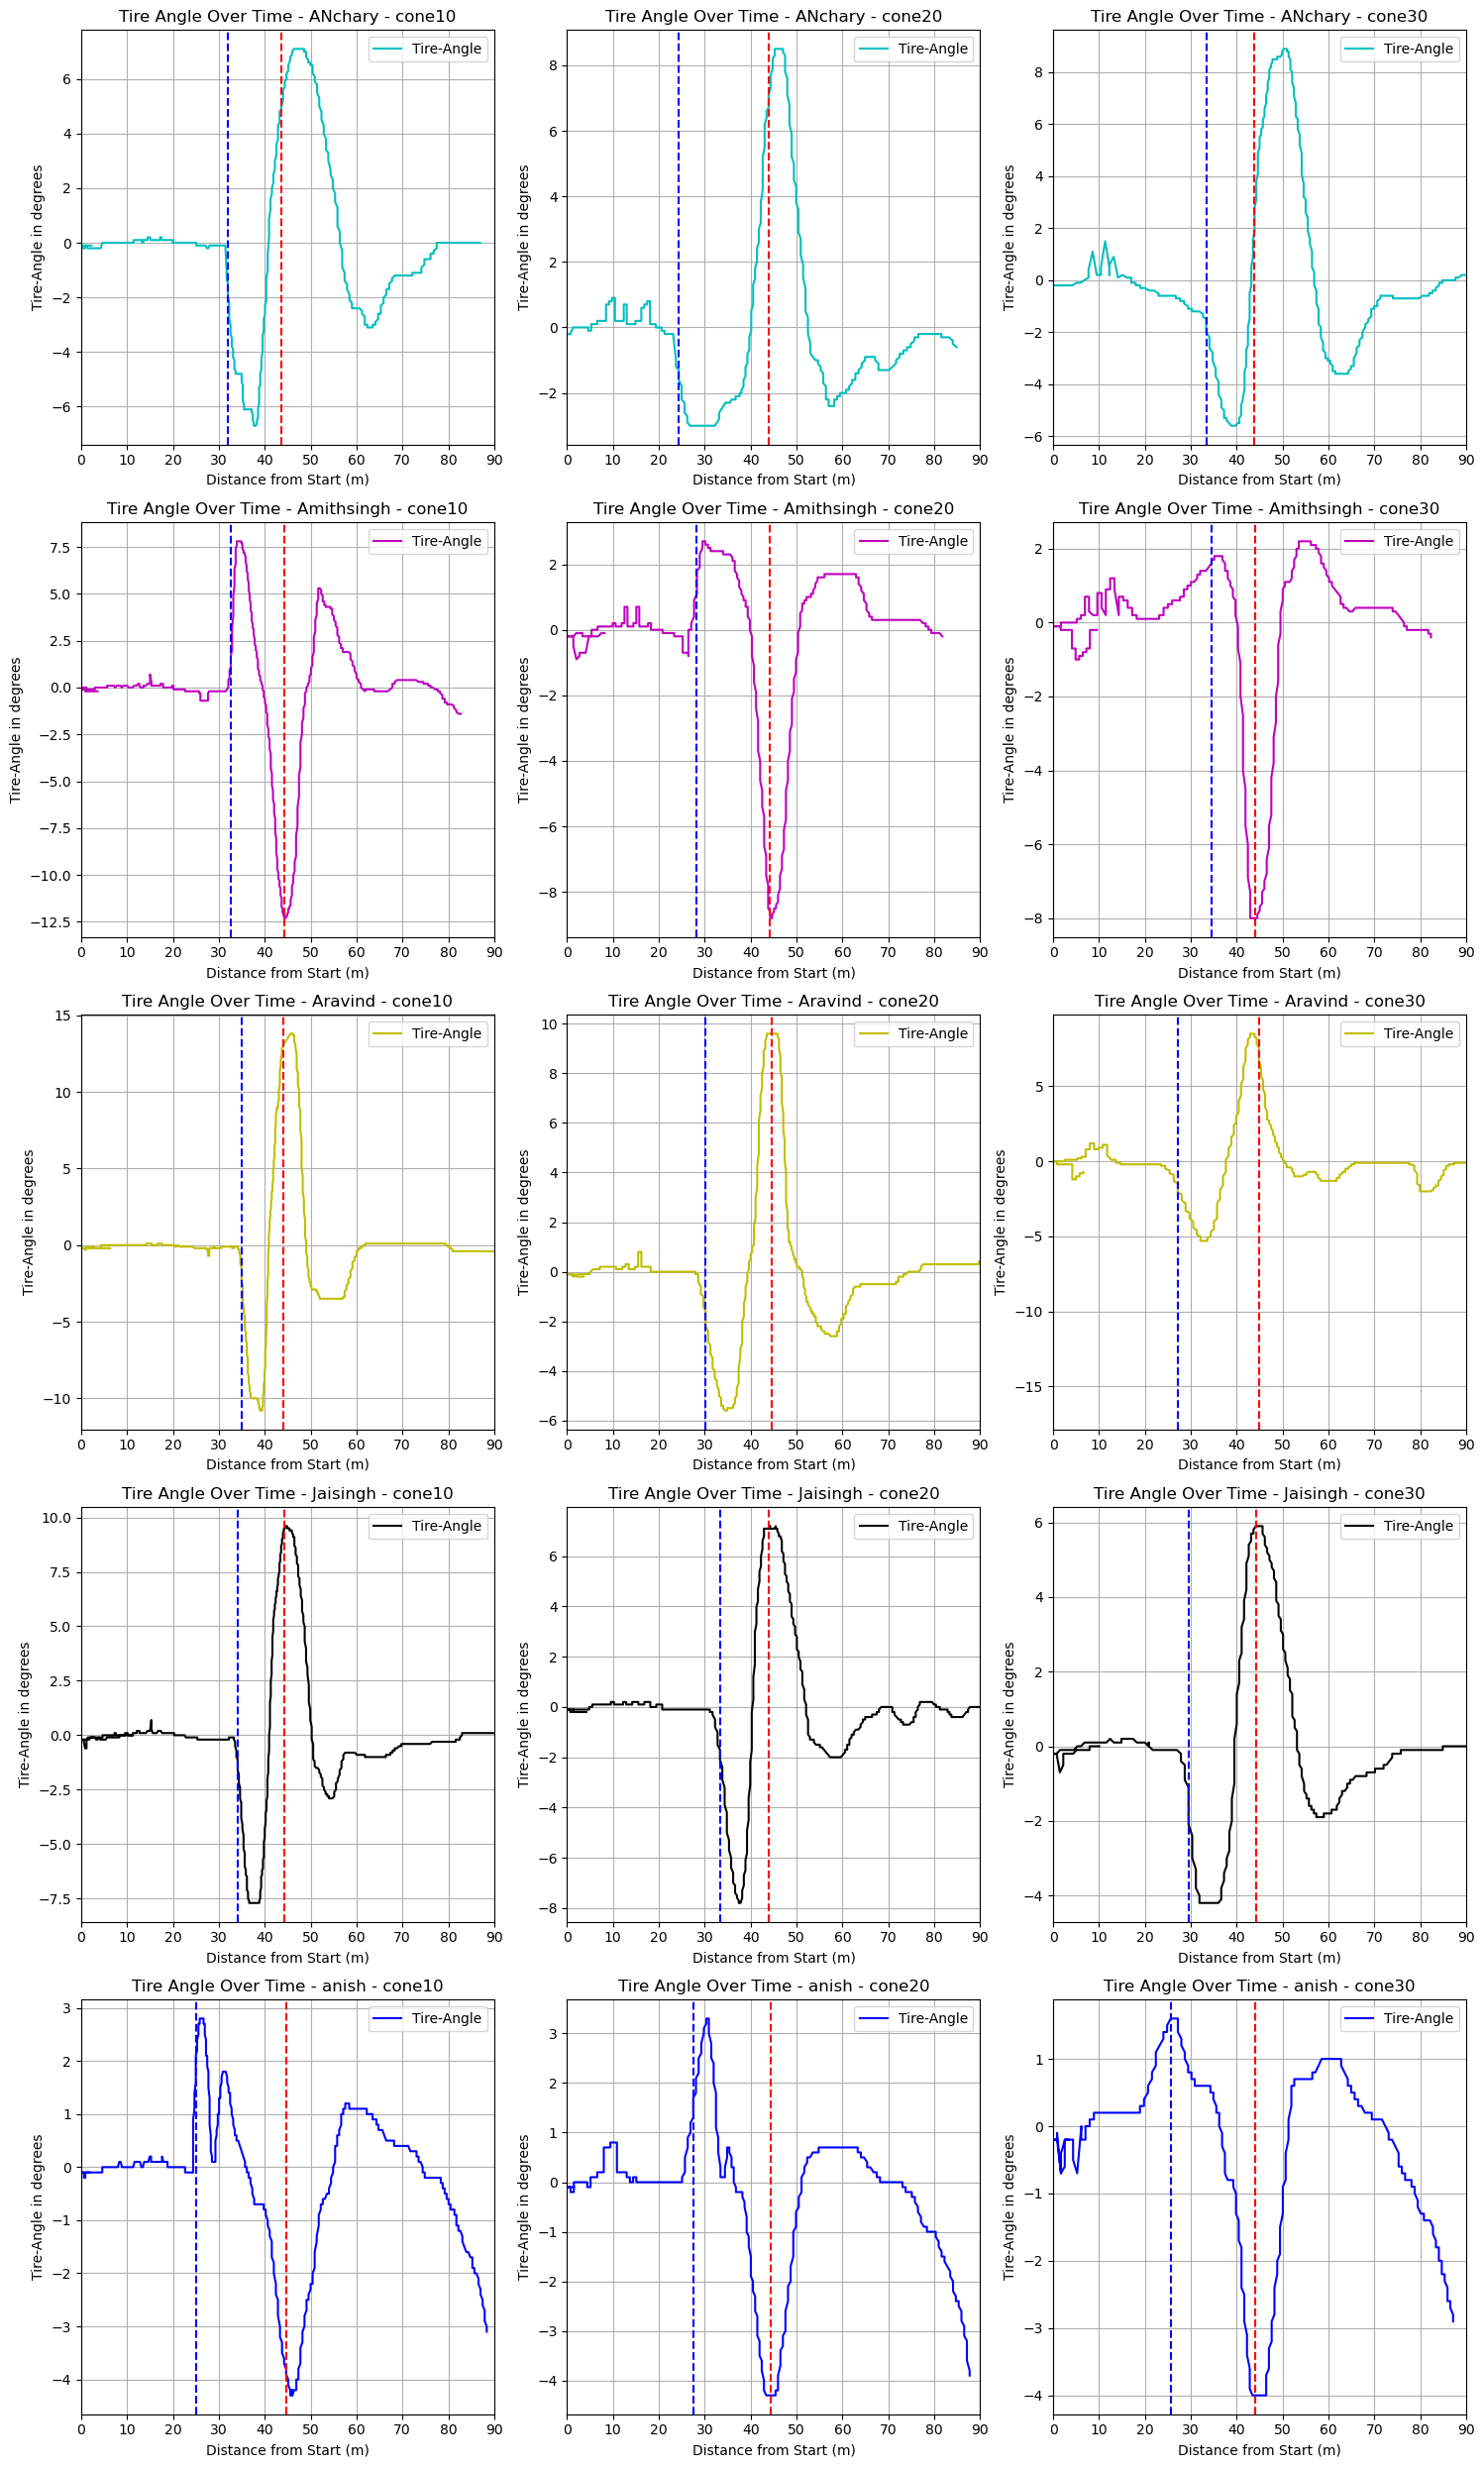

In [10]:
import matplotlib.pyplot as plt

# Determine the number of users and datasets
num_users = max(5, len(data))  # Limit to 5 users
num_datasets = len(next(iter(data.values())))

# Flatten the 2D array of subplots into a 1D array
fig, axs = plt.subplots(num_users, num_datasets, figsize=(15, 5*num_users))
axs_flat = axs.flatten()

# Define a list of colors
colors = ['b', 'g', 'c', 'm', 'y', 'k']

for j, (user_name, user_data) in enumerate(list(data.items())[:num_users]):
    for i, (df_name, df) in enumerate(user_data.items()):
        axs_flat[j * num_datasets + i].plot(df['nearest_dist_from_start'], df['Tire_Angle'], label=f'Tire-Angle', color=colors[(j + 2) % len(colors)])

        axs_flat[j * num_datasets + i].set_xlabel('Distance from Start (m)')
        axs_flat[j * num_datasets + i].set_ylabel('Tire-Angle in degrees')
        axs_flat[j * num_datasets + i].set_title(f'Tire Angle Over Time - {user_name} - {df_name}')
        axs_flat[j * num_datasets + i].grid(True)
        axs_flat[j * num_datasets + i].legend()
        axs_flat[j * num_datasets + i].set_xlim(0, 90)
        
        # Find the 'nearest_dist_from_start' value for the ending point
        ending_dist_from_start = df.loc[ending_point[user_name][df_name], 'nearest_dist_from_start']
        #plot the line for starting point
        starting_point_line = df.loc[starting_point[user_name][df_name], 'nearest_dist_from_start']
        
        axs_flat[j * num_datasets + i].axvline(x=starting_point_line, color='b', linestyle='--')
        axs_flat[j * num_datasets + i].axvline(x=ending_dist_from_start, color='r', linestyle='--')

plt.tight_layout()
plt.show()

### For Reaction Time and Distance

##### For all users Reaction distance 

In [11]:
reaction_distance = {}

for user_name, user_data in data.items():
    reaction_distance[user_name] = {}
    for df_name, df in user_data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_distance[user_name][df_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['nearest_dist_from_start'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['nearest_dist_from_start']
        else:
            reaction_distance[user_name][df_name] = None
    
reaction_distance


{'ANchary': {'cone10': 11.629918308631662,
  'cone20': 19.56577696584937,
  'cone30': 10.542123226871368},
 'Amithsingh': {'cone10': 11.758715870320323,
  'cone20': 15.968655419535587,
  'cone30': 9.487955277252269},
 'Aravind': {'cone10': 8.994833365984348,
  'cone20': 14.322423996667887,
  'cone30': 17.672041735530584},
 'Jaisingh': {'cone10': 10.092986404457776,
  'cone20': 10.559235168285234,
  'cone30': 14.645182888410975},
 'anish': {'cone10': 19.680827040728744,
  'cone20': 16.911784550822816,
  'cone30': 18.398670291063937}}

In [12]:
reaction_distance_mean = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Aravind'].keys():
    reaction_distance_mean[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_distance_mean[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['nearest_dist_from_start'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['nearest_dist_from_start']
        else:
            reaction_distance_mean[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
reaction_distance_df = pd.DataFrame(reaction_distance_mean)

# Calculate the mean for each DataFrame
reaction_distance = reaction_distance_df.mean(axis=0).to_dict()

print(reaction_distance)


{'cone10': 12.431456198024572, 'cone20': 15.465575220232179, 'cone30': 14.149194683825826}


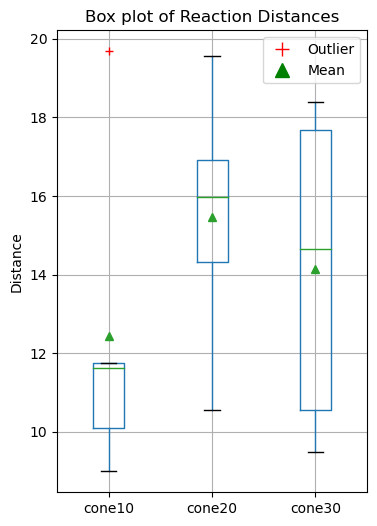

In [13]:
# Draw a box plot of the DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

plt.figure(figsize=(4, 6))  # Adjust the size as needed
reaction_distance_df.boxplot(sym='r+', showmeans=True, )
plt.title('Box plot of Reaction Distances')
plt.ylabel('Distance')
plt.xticks()  # Rotate x-axis labels for better visibility if needed
outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line])

plt.show()

#### For all users Reaction time

In [14]:
reaction_time = {}

for user_name, user_data in data.items():
    reaction_time[user_name] = {}
    for df_name, df in user_data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_time[user_name][df_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Unixtime'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['Unixtime']
        else:
            reaction_time[user_name][df_name] = None
    
reaction_time

{'ANchary': {'cone10': 5, 'cone20': 4, 'cone30': 2},
 'Amithsingh': {'cone10': 5, 'cone20': 3, 'cone30': 2},
 'Aravind': {'cone10': 5, 'cone20': 3, 'cone30': 3},
 'Jaisingh': {'cone10': 5, 'cone20': 2, 'cone30': 3},
 'anish': {'cone10': 6, 'cone20': 4, 'cone30': 2}}

In [15]:
reaction_time_mean = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Aravind'].keys():
    reaction_time_mean[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_time_mean[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Unixtime'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['Unixtime']
        else:
            reaction_time_mean[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
reaction_time_df = pd.DataFrame(reaction_time_mean)

# Calculate the mean for each DataFrame
mean_time = reaction_time_df.mean(axis=0).to_dict()

print(mean_time)


{'cone10': 5.2, 'cone20': 3.2, 'cone30': 2.4}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


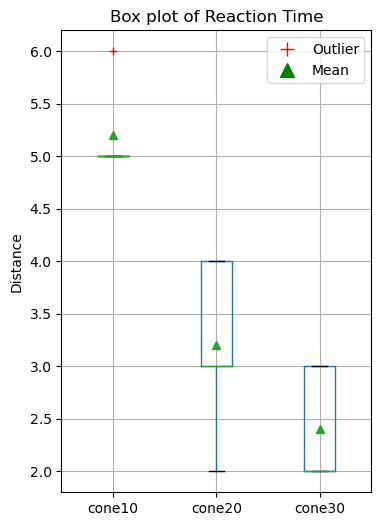

In [16]:
# Draw a box plot of the DataFrame
plt.figure(figsize=(4, 6))  # Adjust the size as needed
reaction_time_df.boxplot(sym='r+', showmeans=True)
plt.title('Box plot of Reaction Time')
plt.ylabel('Distance')
plt.legend()
plt.xticks()  # Rotate x-axis labels for better visibility if needed
outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line])
plt.show()

#### Average Speed at SpeedBreaker

In [17]:
#find average speed at endpoints
speeds = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Aravind'].keys():
    speeds[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            speeds[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Veh_MABX_Speed']
        else:
            speeds[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
speed_df = pd.DataFrame(speeds)

# Calculate the mean for each DataFrame
mean_speed = speed_df.mean(axis=0).to_dict()

print(mean_speed)

{'cone10': 10.54, 'cone20': 14.26, 'cone30': 17.22}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


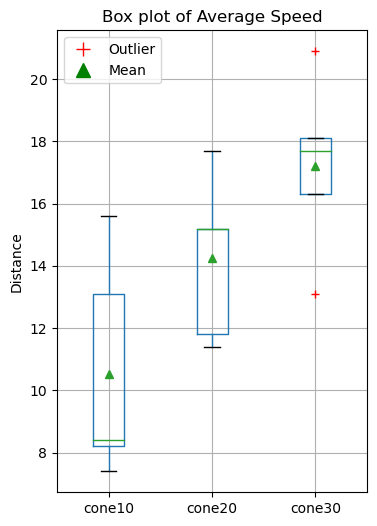

In [18]:
# Draw a box plot of the DataFrame
plt.figure(figsize=(4, 6))  # Adjust the size as needed
speed_df.boxplot(sym='r+', showmeans= True)
plt.title('Box plot of Average Speed')
plt.ylabel('Distance')
plt.legend()
plt.xticks()  # Rotate x-axis labels for better visibility if needed
outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line])
plt.show()

##### To export lat and long of any driver

In [19]:
df_cone20 = data['Aravind']['cone30']

# Select only the 'latitude' and 'Longitude' columns
lat_lng_data = df_cone20[['Lat', 'Lng']]

# Export to CSV
lat_lng_data.to_csv('plot.csv', index=False)

In [20]:
import plotly.express as px
import pandas as pd

# Import data from USGS
data1 = pd.read_csv('/home/ninerishav/TiHANLab-Codes/Solio-Suzuki/navigation/SingletonCodes/autonomous-mode/plot.csv')

# Create scatter map
fig = px.scatter_geo(data1, 
                     lat='Lat', 
                     lon='Lng', 
                     scope='asia', 
                     title='Pothole Location', 
                     projection='natural earth', 
                     color_discrete_sequence=['blue'], 
                     width=1200, 
                     height=800, 
                     opacity=0.5, 
                     labels={'latitude': 'Latitude', 'longitude': 'Longitude'}, 
                     template='plotly_dark', 
)
# add one point to the scatter plot
pothole_lat = 17.602129066824
pothole_lon = 78.126623770904

fig.add_trace(
    px.scatter_geo(lat=[pothole_lat], lon=[pothole_lon], color_discrete_sequence=['red'], width=1200, height=800, title='Pothole Location').data[0]
)

fig.update_layout(title_text='Pothole Data collection', xaxis_title='Longitude', yaxis_title='Latitude')
fig.show()


In [21]:
import plotly.io as pio
pio.write_html(fig, file='pothole.html', auto_open=False)

### lateral Distance 


lateral distance dx is calculated from the (lat,long points of pothole distance location) 17°36'07.5"N 78°07'35.9"E  to the (min negative value of tyre_angle ) where the vehcile is straight to the lat, long co-ordinates of the pothole location 

In [22]:
import numpy as np

def degrees_to_radians(degrees):
    return np.radians(degrees)
    
# Function to calculate the lateral distance `dx`
def calculate_lateral_distance(lat1, lon1, lat2, lon2, bearing=None):
    # Convert latitudes and longitudes from degrees to radians
    lat1, lon1, lat2, lon2 = map(degrees_to_radians, [lat1, lon1, lat2, lon2])
    
    # Calculate differences
    dlon = lon2 - lon1
    
    # Calculate bearing if not provided
    if bearing is None:
        y = np.sin(dlon) * np.cos(lat2)
        x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
        bearing = np.arctan2(y, x)
    
    # Calculate lateral distance 'dx'
    dx = np.arcsin(np.sin(dlon) * np.cos(lat2) / np.sin(bearing)) * 6371 * 1000  # Earth radius in meters
    return dx

pothole_lat = 17.602129066824
pothole_lon = 78.126623770904

lat_lng = {}
dx_distances = {}

# Iterate over each dataset for each driver
for dataset in ['cone10', 'cone20', 'cone30']:
    lat_lng[dataset] = {}
    dx_distances[dataset] = {}  # Initialize the dictionary for the current dataset
    for driver_name, driver_datasets in data.items():
        driver_df = driver_datasets[dataset]
        selected_data = data[driver_name][dataset].iloc[ending_point[driver_name][dataset]]
        vehicle_lat, vehicle_lon = selected_data['Lat'], selected_data['Lng']
        # Store the 'Lat' and 'Lng' in the dictionary under the current dataset and driver
        lat_lng[dataset][driver_name] = (vehicle_lat, vehicle_lon)

        dx = calculate_lateral_distance(pothole_lat, pothole_lon, vehicle_lat, vehicle_lon)
        # Store the `dx` in the dictionary under the current dataset and driver
        dx_distances[dataset][driver_name] = dx


# Print out the latitudes and longitudes for all drivers in each dataset
# for dataset, lat_lngs in lat_lng.items():
#     print(f"\n{dataset} Latitudes and Longitudes:")
#     for driver, (lat, lng) in lat_lngs.items():
#         print(f"Driver {driver}: Latitude = {lat}, Longitude = {lng}")

# Print out the lateral distances 'dx' for all drivers in each dataset
for dataset, distances in dx_distances.items():
    print(f"\n{dataset} Lateral Distances:")
    for driver, distance in distances.items():
        print(f"Driver {driver}: {distance:.2f} meters")

# filter values larger than 2
dx_distances_filtered = {dataset: {driver: distance for driver, distance in distances.items() if distance < 2} for dataset, distances in dx_distances.items()}

# Calculate the mean lateral distance for each dataset
mean_lateral_distances_filtered = {dataset: np.nanmean(list(distances.values())) for dataset, distances in dx_distances_filtered.items()}
mean_lateral_distances_filtered



cone10 Lateral Distances:
Driver ANchary: 0.69 meters
Driver Amithsingh: 4.14 meters
Driver Aravind: 0.57 meters
Driver Jaisingh: 0.74 meters
Driver anish: 4.05 meters

cone20 Lateral Distances:
Driver ANchary: 0.64 meters
Driver Amithsingh: 4.16 meters
Driver Aravind: 0.36 meters
Driver Jaisingh: 0.90 meters
Driver anish: 3.94 meters

cone30 Lateral Distances:
Driver ANchary: 0.73 meters
Driver Amithsingh: 4.12 meters
Driver Aravind: 0.53 meters
Driver Jaisingh: 0.67 meters
Driver anish: 3.95 meters


{'cone10': 0.6671424967315885,
 'cone20': 0.6311538047474169,
 'cone30': 0.6438318448923225}

#### For Center TO center distance

In [23]:
# Convert the mean lateral distances from meters to centimeters
mean_lateral_distances_cm = {dataset: distance * 100 for dataset, distance in mean_lateral_distances_filtered.items()}

CAR_CENTER_TO_POTHOLE_CENTER = 80  # in cm
# subtract 80 cm from the mean lateral distance
mean_lateral_distances_cm['cone10'] -= CAR_CENTER_TO_POTHOLE_CENTER
mean_lateral_distances_cm['cone20'] -= CAR_CENTER_TO_POTHOLE_CENTER
mean_lateral_distances_cm['cone30'] -= CAR_CENTER_TO_POTHOLE_CENTER

mean_lateral_distances_cm

{'cone10': -13.28575032684114,
 'cone20': -16.88461952525831,
 'cone30': -15.61681551076775}

 Color Gradient 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

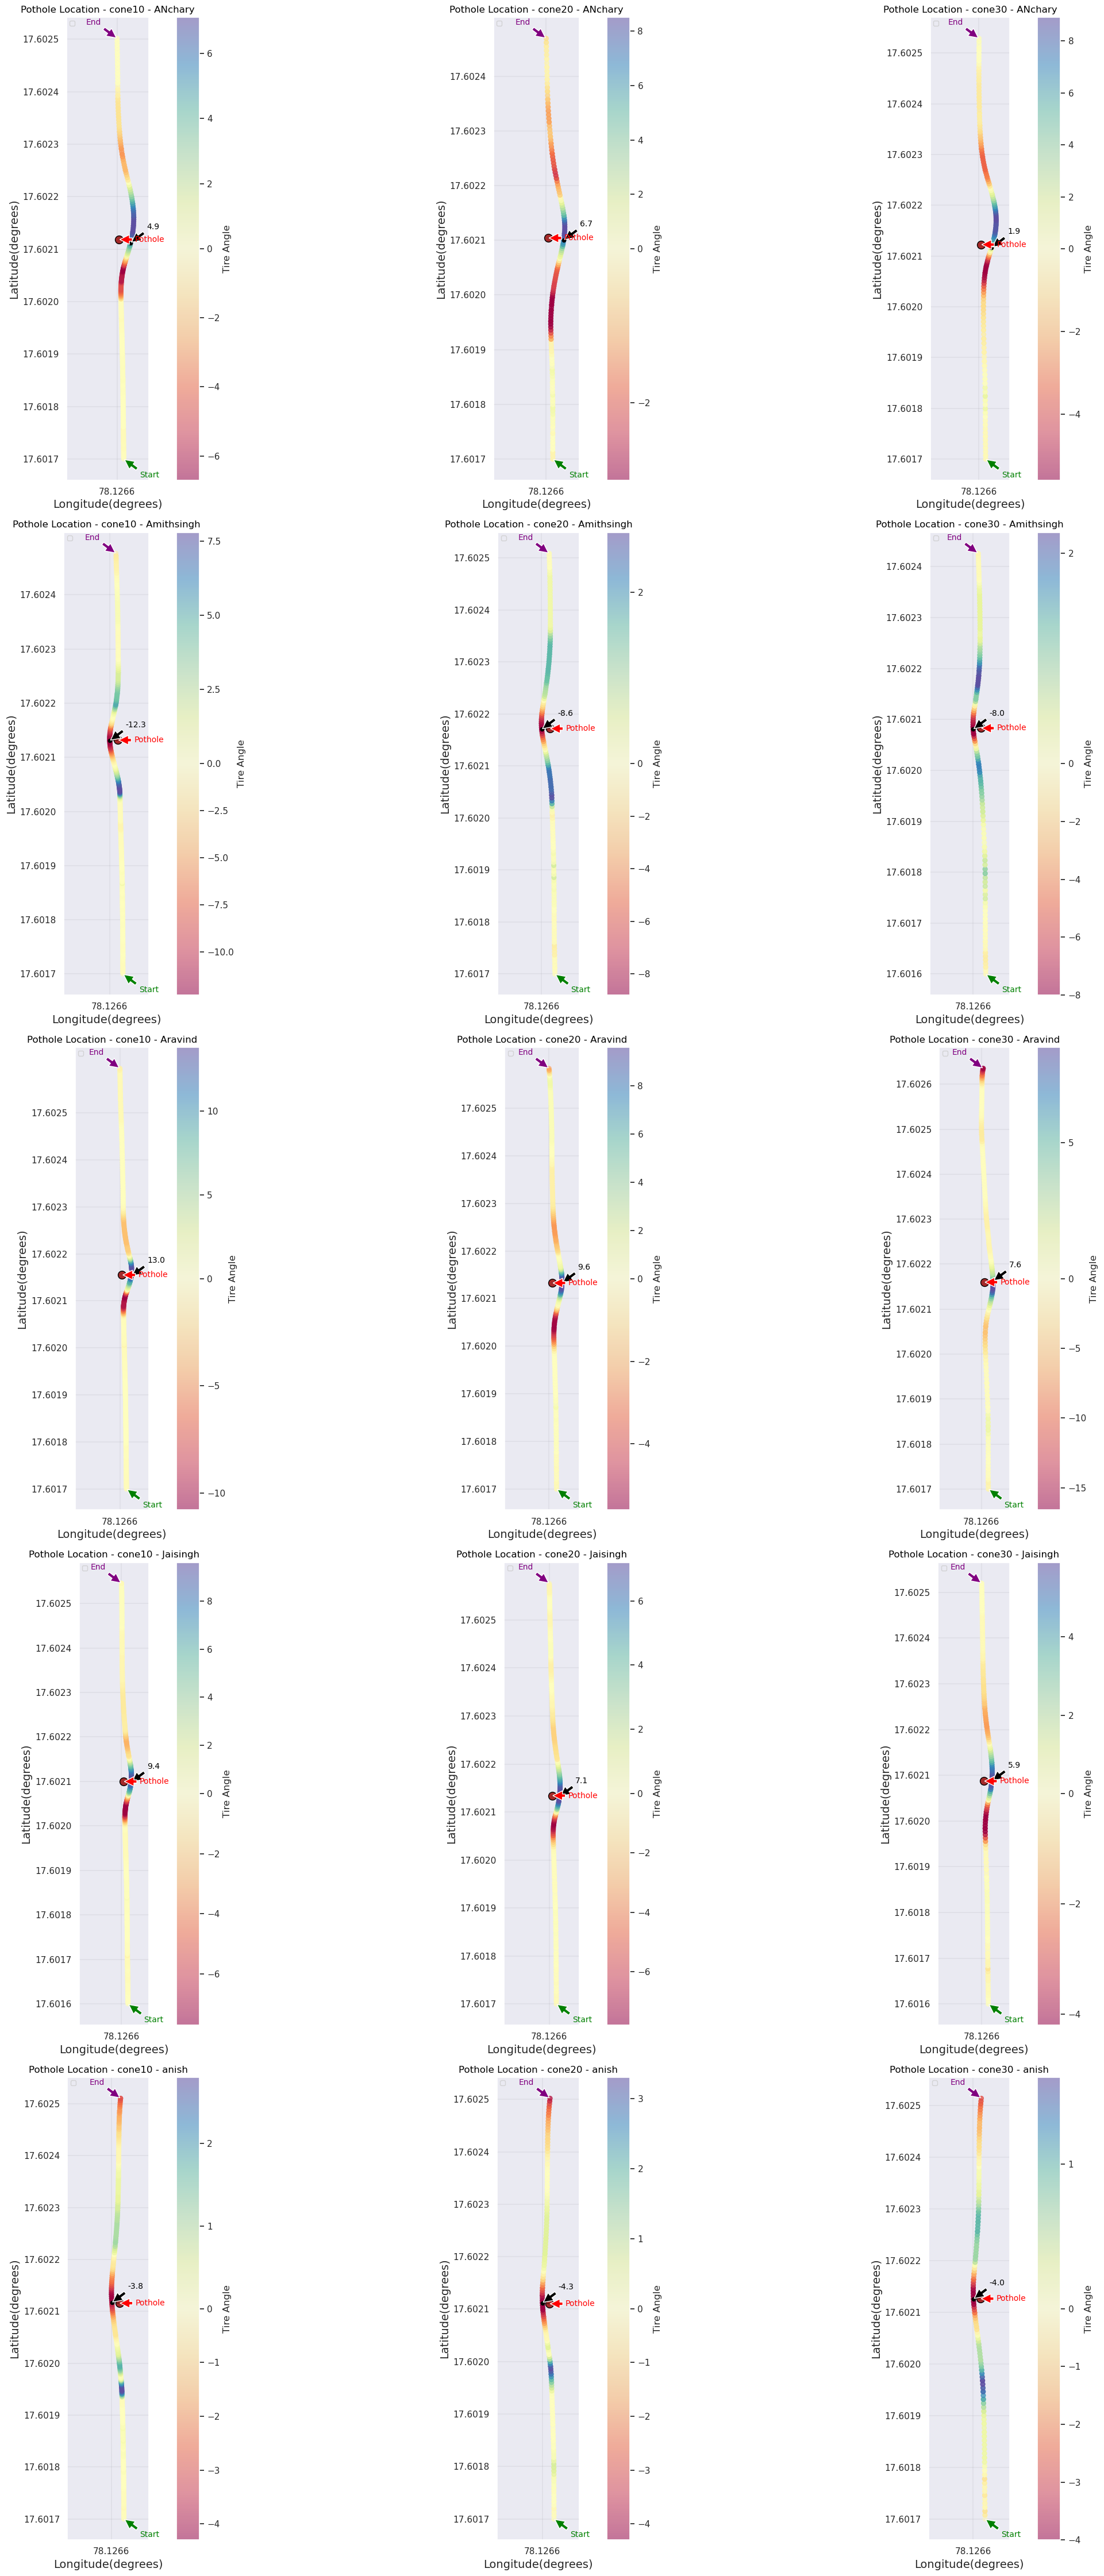

In [24]:
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

# Set seaborn style
sns.set(style="darkgrid")
users = 5
# Create a figure with subplots for each driver and each dataset

fig, axs = plt.subplots(users, num_datasets, figsize=(25, 9*users))

# Use a colormap for user differentiation
cmap = sns.color_palette("hsv", num_datasets)

given_lat, given_lon = 17.602129204103562, 78.12660004713902

for j, (driver_name, driver_data) in enumerate(list(data.items())[:users]):
    for i, (df_name, df) in enumerate(driver_data.items()):
        # Disable scientific notation for axis labels
        ax = axs[j, i]
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
        
        # Get lateral_lat, lateral_long from lat_lng for each dataset and driver
        selected_data = df.iloc[ending_point[driver_name][df_name]]
        lateral_lat, lateral_long = selected_data['Lat'], selected_data['Lng']
        
        # Convert DataFrame to GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Lng'], df['Lat']))
        
        # Scatter plot with transparency and size adjustments for better visibility
        # Add tire angle as color gradient
        tire_angle = df['Tire_Angle']

        tire_angle_lat_lng = df.iloc[ending_point[driver_name][df_name]]['Tire_Angle']
        # print(tire_angle_lat_lng)
        
        # norm = mcolors.Normalize(vmin=tire_angle.min(), vmax=tire_angle.max())
        norm = mcolors.TwoSlopeNorm(vmin=tire_angle.min(), vcenter=0, vmax=tire_angle.max())
        scatter = axs[j, i].scatter(df['Lng'], df['Lat'], c=tire_angle, cmap='Spectral', norm=norm, alpha=0.5, s=30)
        # Set x and y ticks to show actual latitudes and longitudes
        axs[j, i].set_xticks(np.arange(df['Lng'].min(), df['Lng'].max(), 0.0001))
        axs[j, i].set_yticks(np.arange(df['Lat'].min(), df['Lat'].max(), 0.0001))

        # Format the ticks to show 4 decimal places
        axs[j, i].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
        axs[j, i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))

        # Add colorbar (scale)
        fig.colorbar(scatter, ax=axs[j, i], orientation='vertical', label='Tire Angle')
        
        # Highlight the given point and lateral point with different colors and sizes
        given_point = gpd.GeoDataFrame(geometry=[Point(given_lon, given_lat)])
        given_point.plot(ax=axs[j, i], color='brown', alpha=1.0, markersize=100, edgecolors='black', linewidths=1)
        
        lateral_point = gpd.GeoDataFrame(geometry=[Point(lateral_long, lateral_lat)])
        lateral_point.plot(ax=axs[j, i], color='black', alpha=1.0, markersize=20, edgecolors='black', linewidths=1)
        
        # Annotate the tire angle at the lateral point
        axs[j, i].annotate(f'{tire_angle_lat_lng}', (lateral_long, lateral_lat), xytext=(20, 20),
                textcoords='offset points', va='center', ha='left', fontsize=10, color='black',
                arrowprops=dict(facecolor='black', shrink=0.05))
    
        axs[j, i].set_xlabel('Longitude(degrees)', fontsize=14)
        axs[j, i].set_ylabel('Latitude(degrees)', fontsize=14)
        axs[j, i].set_title(f'Pothole Location - {df_name} - {driver_name}', fontsize=12, color='black')
        axs[j, i].legend(loc='upper left', fontsize=8)
        axs[j, i].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
        
        axs[j, i].set_xlim([78.1265001, 78.126657])
        
        # Annotate the pothole with a red arrow for better visibility
        axs[j, i].annotate('Pothole', (given_lon, given_lat), xytext=(20, 0),
                    textcoords='offset points', va='center', ha='left', fontsize=10, color='red',
                    arrowprops=dict(facecolor='red', shrink=0.05))
        
        # Annotate the start and end points
        start_point = df.iloc[0]
        end_point = df.iloc[-1]
        axs[j, i].annotate('Start', (start_point['Lng'], start_point['Lat']), xytext=(20, -20),
                    textcoords='offset points', va='center', ha='left', fontsize=10, color='green',
                    arrowprops=dict(facecolor='green', shrink=0.05))
        axs[j, i].annotate('End', (end_point['Lng'], end_point['Lat']), xytext=(-20, 20),
                    textcoords='offset points', va='center', ha='right', fontsize=10, color='purple',
                    arrowprops=dict(facecolor='purple', shrink=0.05))
        
        # Draw a line between pothole and lateral point with a thicker line for better visibility
        line = gpd.GeoDataFrame(geometry=[LineString([(given_lon, given_lat), (lateral_long, lateral_lat)])])
        line.plot(ax=axs[j, i], color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

Wrong Method used to plot earlier

In [25]:
# # Set seaborn style
# sns.set(style="darkgrid")

# # Create a figure with subplots for each driver and each dataset
# fig, axs = plt.subplots(num_users, num_datasets, figsize=(15, 5*num_users))

# # Use a colormap for user differentiation
# cmap = sns.color_palette("hsv", num_datasets)

# given_lat, given_lon = 17.602129204103562, 78.12660004713902

# for j, (driver_name, driver_data) in enumerate(data.items()):
#     for i, (df_name, df) in enumerate(driver_data.items()):
#         # Get lateral_lat, lateral_long from lat_lng for each dataset and driver
#         selected_data = df.iloc[ending_point[driver_name][df_name]]
#         lateral_lat, lateral_long = selected_data['Lat'], selected_data['Lng']
        
#         # Scatter plot with transparency and size adjustments for better visibility
#         axs[j, i].scatter(df['Lng'], df['Lat'], label=f'{driver_name} Speed {(i+1*10)}', color=cmap[i], alpha=0.5, s=30)
        
#         # Highlight the given point and lateral point with different colors and sizes
#         axs[j, i].scatter(given_lon, given_lat, color='red', alpha=1.0, s=100, edgecolors='black', linewidths=1)
#         axs[j, i].scatter(lateral_long, lateral_lat, color='blue', alpha=1.0, s=75, edgecolors='black', linewidths=1)
        
#         axs[j, i].set_xlabel('Longitude', fontsize=14)
#         axs[j, i].set_ylabel('Latitude', fontsize=14)
#         axs[j, i].set_title(f'Pothole Location - {df_name}', fontsize=12, color='black')
#         axs[j, i].legend(loc='upper left', fontsize=8)
#         axs[j, i].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
        
#         # Annotate the pothole with a red arrow for better visibility
#         axs[j, i].annotate('Pothole', (given_lon, given_lat), xytext=(20, 20),
#                     textcoords='offset points', va='center', ha='left', fontsize=10, color='red',
#                     arrowprops=dict(facecolor='red', shrink=0.05))
        
#         # Draw a line between pothole and lateral point with a thicker line for better visibility
#         axs[j, i].plot([given_lon, lateral_long], [given_lat, lateral_lat], color='black', linestyle='--', linewidth=1, alpha=0.5)

# plt.tight_layout()
# plt.show()